# Introduction to Japanese Text Mining

This Jupyter notebook introduces the procedures known as Multi-Dimensional Scaling and Most Distinctive Words analysis. The first is a means for understanding the lexical distance between documents. The second is a means of extracting words that most distinguish two groups of documents.

This notebook has been created to work on a toy set of **Japanese** texts. To run this notebook, you will need the following items placed into the same folder in which this jupyter notebook file is located:<br>
- A folder called "JapaneseTextFiles" containing the sample corpus<br>
- A .csv file called "JapaneseTextsMetadata.csv"<br>
- A stopwords list called "Stopwords_jp.txt"<br>

# PART 1: Document Similarity
The first part of this notebook will show you how to take a set of pre-tokenized documents and load them into a table format known as a **document-term-matrix**. This converts your documents into **word vectors**. With this matrix, you can perform a variety of distance calculations on the documents as a way to compare their diction.

## Import Python Libraries

In [1]:
#import some of the python packages you will be using in the next steps

from scipy import stats
import os
import numpy as np

## Read in a List of Files
Read in a list of files from a directory. These texts have already been tokenized using the **MeCab** tokenizer. You can use the MeCab tokenizer in either Python or R, and it can be installed on Mac or PC, although installation on the latter can be more difficult. For instructions on how to install MeCab on a Mac and for a sample Python script, see Molly des Jardin's fantastic website: http://guides.library.upenn.edu/japanesetext. A tutorial for how to install and run MeCab in R can be found here: http://history.emory.edu/RAVINA/JF_text_mining/Guides/MeCab_RMeCab.html.

In [2]:
#grab pathnames of all text files in this directory of tokenized files
directory = r'JapaneseTexts\\' 

#create an empty list to store file paths
filenames = []

#iterate through each file in the directory, append the filename to directory, and store path in list
for file in os.listdir(directory):
    filenames.append(directory+file)
    
#check number of files
print(len(filenames))

#examine filenames  
filenames

20


['JapaneseTexts\\\\1207.txt',
 'JapaneseTexts\\\\1220.txt',
 'JapaneseTexts\\\\1293.txt',
 'JapaneseTexts\\\\1431.txt',
 'JapaneseTexts\\\\1669.txt',
 'JapaneseTexts\\\\1676.txt',
 'JapaneseTexts\\\\1702.txt',
 'JapaneseTexts\\\\1726.txt',
 'JapaneseTexts\\\\24376.txt',
 'JapaneseTexts\\\\33.txt',
 'JapaneseTexts\\\\3310.txt',
 'JapaneseTexts\\\\38.txt',
 'JapaneseTexts\\\\43662.txt',
 'JapaneseTexts\\\\46587.txt',
 'JapaneseTexts\\\\48075.txt',
 'JapaneseTexts\\\\51218.txt',
 'JapaneseTexts\\\\51270.txt',
 'JapaneseTexts\\\\52396.txt',
 'JapaneseTexts\\\\783.txt',
 'JapaneseTexts\\\\843.txt']

## Import Document Metadata

In [3]:
import pandas as pd
from pandas import Series, DataFrame

#Read in metadata from your .xlsx file and create a DataFrame
df = pd.read_excel(r'JapaneseTextsMetadata.xlsx', sheetname='JapaneseTextsMetadata')

#sort by file_id so that metadata is in same order as filenames 
df = df.sort_values(by='FILE_ID')

#reset index
df = df.reset_index(drop=True)

#check the metadata
df

,FILE_ID,TITLE,AUTH_LAST,AUTH_FIRST,PUBL_DATE,GENRE
0,1207.txt,Tandeki,Homei,Iwano,1909,SHISHOSETSU
1,1220.txt,Majan satsujin jiken,Unno,Juza,1931,POPULAR
2,1293.txt,Hanshichi torimonocho (no1),Okamoto,Kido,1917,POPULAR
3,1431.txt,Kumo,Kouga,Saburo,1930,POPULAR
4,1669.txt,Futon,Katai,Tayama,1907,SHISHOSETSU
5,1676.txt,Kurokami,Chikamatsu,Shuko,1922,SHISHOSETSU
6,1702.txt,Kabi,Tokuda,Shusei,1911,SHISHOSETSU
7,1726.txt,Daibosatsu toge (no 1),Nakazato,Kaizan,1913,POPULAR
8,24376.txt,Tange sazen: Part 1,Hayashi,Fubou,1927,POPULAR
9,33.txt,Omedetaki hito,Mushanokoji,Saneatsu,1910,SHISHOSETSU


## Create Word Frequency Table ("Document-Term-Matrix")
A document-term-matrix is a large table where **rows** correspond to each document in your corpus and **columns** correspond to each word in your corpus. Each entry in the table represents a value associated with a given word in a particular document. This might be the **raw count** of that word, the **normalized count** of that word, or some other measure, like the **term-frequency inverse document frequency**. To create our document-term-matrix, or DTM, we will be using a function called **CountVectorizer**. 

In [33]:
#do necessary imports
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#create vectorizer instance and set necessary parameters
#option 1: include all words in the corpus and calculate their raw frequency
#the token pattern tells the vectorizer to treat every sequence of non-spacs as a word
vectorizer = CountVectorizer(input='filename', encoding='utf-8', token_pattern='[^\s]+') 

#build the document-term-matrix by feeding in list of filepaths
dtm = vectorizer.fit_transform(filenames) 

#grab the vocabulary items from the results; this will be the complete vocabulary for all documents
dtm_vocab = vectorizer.get_feature_names()

#convert both the dtm and vocab list to regular arrays
dtm = dtm.toarray()  
dtm_vocab = np.array(dtm_vocab)

#check size of document-term-matrix
dtm.shape

(20, 33770)

## Word Vectors
Each row in our document-term-matrix can be treated as a **word vector**. A vector is simply a sequence of numbers wherein each number represents the value of some variable (or attribute) associated with a particular data point. In this case, the variable is the raw frequency of a particular word. Seen this way, our document-term-matrix is a collection of 20 vectors and 30,888 variables (i.e., the number of unique words in the corpus). What’s great about these vector representations of each text is that we now have a way to compare many texts via mathematical operations. Each text is now an arrow pointing out into a high dimensional space (a space with 30,888 dimensions!) and there are easy ways to compare the distances between arrows based on where they point in this space. This is known as the vector space model.

<img src = "vector_space.png">

Within the vector space model, there are multiple ways of manipulating the vectors in order to compare them. We will look at the following methods in this part of the tutorial:

- Euclidean Distance
- Cosine Similarity

These methods are closely related and rely on the geometrical properties inherent to vectors. If we think of these vectors as pointing out into n-dimensional space, then **Euclidean Distance** and **Cosine Similarity** are two different ways of measuring how close any two vectors are in this space. They differ, however, in that Euclidean is more sensitive to length than Cosine because the former measures distance between the endpoints of the vectors. Thus one must be careful to normalize one’s vectors before using Euclidean distance, otherwise the differences between texts may only reflect their size (e.g., the more words in a text, the further its vector will point).

Cosine similarity, in contrast, measures the cosine of the angle between two vectors and is thus not susceptible to differences in length. It is a similarity measure, not a distance measure, and ranges from 0 to 1. The closer to 1 it is, the more similar two word vectors are. To express as a distance, we subtract the cosine similarity from 1.

<img src = 'euclidean_cosine.png'>

## Vector Normalization
This brings us to an important point about the importance of **normalizing vectors**. We want to be sure that we’re comparing texts on the same scale. We can do this by normalizing our word counts by document length, producing relative frequencies (e.g., expressing the frequency as a percentage of all words in the document).

In [5]:
#normalize by number of words in each document and multiply by 100
norm_dtm = 100 * dtm / np.sum(dtm, axis=1, keepdims=True)

#check results
norm_dtm[0:10, 0:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.0032831 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

## TF-IDF Normalization
But there are other ways to normalize our texts depending on the kind of information we want to extract from them. One problem with relative frequencies is that they give a lot of weight to high frequency terms (e.g., like the particle を). A lot of high frequency words, however, are not distinguishing features between texts. If lots of documents use the particle を, then it doesn’t tell us a great deal about differences between documents. One method for down weighting such terms is the **term-frequency inverse-document frequency (tf-idf)** method. This method re-weights words according to how often they occur across a corpus, giving less weight to terms that appear in many documents and more weight to terms that appear in only a few documents. The formula is given below. The logarithm in the denominator ensures that rarer terms will be given a higher weight. To create a DTM with tf-idf values, we simply use a differnet **Vectorizer** in the scikit learn library. The difference now is that values for some of the common, high frequency words is lower than the values for rarer, less frequent words.

<img src = 'tf-idf.gif'>

## Create TF-IDF Document Term Matrix

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

#option 2: include all words in the corpus and calculate their tfidf value
vectorizer = TfidfVectorizer(input='filename', encoding='utf-8', token_pattern='[^\s]+', norm='l2') 

#build the document-term-matrix by feeding in list of filepaths
tfidf_dtm = vectorizer.fit_transform(filenames) 

#grab the vocabulary items from the results; this will be the complete vocabulary for all documents
tfidf_vocab = vectorizer.get_feature_names()

#convert both the dtm and vocab list to regular arrays
tfidf_dtm = tfidf_dtm.toarray()  
tfidf_vocab = np.array(tfidf_vocab)

#check size of document-term-matrix
tfidf_dtm.shape

(20, 33770)

In [35]:
#compare values of a high frequency word common to all documents and a rarer word present in only a few

print(dtm[16, dtm_vocab == 'は'])
print(norm_dtm[16, dtm_vocab == 'は'])
print(tfidf_dtm[16, tfidf_vocab == 'は'])

print(dtm[16, dtm_vocab == '私'])
print(norm_dtm[16, dtm_vocab == '私'])
print(tfidf_dtm[16, tfidf_vocab == '私'])

[656]
[ 4.02602185]
[ 0.29894154]
[437]
[ 2.68196882]
[ 0.20885865]


## Feature Selection
Once you’ve normalized your texts into comparable units, the next question to consider is whether you need all the dimensions that are available to you. Or to put it another way, is there a way to reduce the dimensions to filter out some of the noise introduced by having so many words? All of the words may not be important to the question you are trying to answer. This process of reducing the dimensions is called **feature selection**. Here are some common methods for reducing features:

- Retain only those words that occur more than X number of times.
- Filter out the grammatical function words (or stopwords). These can be good indicators of authorial style, but they are less useful for identifying differences in content. Lists of stopwords should be tailored to whatever corpus you are working with and are typically created using the most frequent words in the corpus.
- Lemmatize or stem the words in your corpus, reducing them to their base forms. In this way, one can collapse all of the variants of a word into a single term. Lemma can easily be extracted from the MeCab/Unidic output, as discussed in a previous session.

Here, we will perform two kinds of feature selection on the corpus before proceeding with our analysis. First we will import a stopword list to use with our Vectorizers. Then we will set a **min_df** parameter to filter out all terms occurring less than X number of times and a **max_features** parameter to include only the top Y most frequent words.

## Import Stopword List

In [8]:
#set directory path of stopword list
stopword_file = r'Stopwords_jp.txt'
#read in stopword file
text = open(stopword_file, encoding="utf-8")
raw = text.read()

#turn stopwords into a list that python can process
raw = raw.split('\n')   #split on newline
jp_stopwords = []       #create empty list to store words

#iterate through words in file and append to list
for word in raw:         
    jp_stopwords.append(word)

#check length of stopword list
print(str(len(jp_stopwords)) + ' total stopwords\n') 
    
#print first ten items in list
for el in jp_stopwords[0:10]:
    print(el)

735 total stopwords

の
た
に
て
を
は
が
と
で
も


In [36]:
#option 3: filter stopwords and include only words that occur more than 2 times
vectorizer = CountVectorizer(input='filename', min_df= 2, max_features = 2000, 
                             encoding='utf-8', token_pattern='[^\s]+', stop_words=jp_stopwords)

#build the document-term-matrix by feeding in list of filepaths
reduced_dtm = vectorizer.fit_transform(filenames) 

#grab the vocabulary items from the results; this will be the complete vocabulary for all documents
red_vocab = vectorizer.get_feature_names()

#convert both the dtm and vocab list to regular arrays
reduced_dtm = reduced_dtm.toarray()  
red_vocab = np.array(red_vocab)

#check size of document-term-matrix
reduced_dtm.shape

(20, 2000)

In [10]:
#normalize the new DTM
red_norm_dtm = 100 * reduced_dtm / np.sum(reduced_dtm, axis=1, keepdims=True)

## Calculate Distance between Documents
We are finally ready to start comparing our texts. At this point we will also start using the metadata for these works since we will need this to label our visualizations. Let's use the final DTM we created, which uses normalized frequencies with feature selection (e.g., no stopwords, max_features = 2000).

In [17]:
#import necessary packages
from sklearn.metrics.pairwise import euclidean_distances

#calculate euclidean distances
euc_dist = euclidean_distances(red_norm_dtm)

#show titles of texts again
print(df.iloc[9].TITLE)
print(df.iloc[14].TITLE)
print(df.iloc[11].TITLE, '\n')

# the distance between "Omedetaki hito" and "Shi no seppun"; and between "Omedetaki hito" and "Wakai"
print(dist[9, 14])
print(dist[9, 11], '\n')

# is distance of "Omedetaki hito" from "Shi no seppun" greater than distance from "Wakai"?
print(dist[14, 9] > dist[9, 11])

Omedetaki hito
Shi no seppun
Wakai 

0.624932503013
0.243680503111 

True


## Visualize Distances between Documents
**Multi-Dimensional Scaling**: This statistical transformation tries to assign a point in a plane to each text, making sure that the distance between points is proportional to their pairwise distances in n-dimensional space. Information is necessarily lost in the process, but the idea is to capture higher-dimensional relations in a lower-dimensional space.

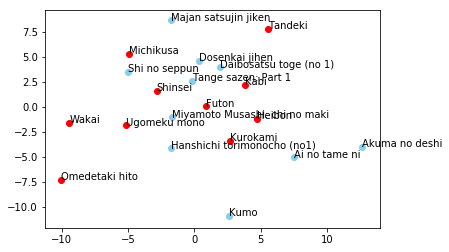

In [18]:
#plot the distances
#visualize distances using multidimensional scaling
import os  # for os.path.basename
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(euc_dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]  #get all the x-values and y-values into separate variables

#generate a list of titles and genres from the metadata
names = df.TITLE.tolist()
genres = df.GENRE.tolist()

#plot each point using titles as labels and genre as color
for x, y, name, genre in zip(xs, ys, names, genres):
    color = 'red' if genre == "SHISHOSETSU" else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)

plt.show()

## Calculate Cosine Similarity of Documents

In [16]:
#import necessary function
from sklearn.metrics.pairwise import cosine_similarity

#calculate the cosine similarity between texts
#we subtract the cosine-similarity from 1 to get a "distance" measure, rather than a similarity measure
#i.e., the smaller the similarity, the greater the distance (subtracting from 1 reflects this)
cos_dist = 1 - cosine_similarity(red_norm_dtm)

#inspect the distance matrix
np.round(cos_dist, 2)

array([[ 0.  ,  0.82,  0.76,  0.88,  0.6 ,  0.7 ,  0.64,  0.71,  0.74,
         0.77,  0.72,  0.75,  0.72,  0.79,  0.75,  0.67,  0.85,  0.76,
         0.78,  0.65],
       [ 0.82, -0.  ,  0.75,  0.77,  0.71,  0.77,  0.72,  0.72,  0.75,
         0.84,  0.75,  0.83,  0.72,  0.8 ,  0.55,  0.79,  0.85,  0.69,
         0.53,  0.59],
       [ 0.76,  0.75,  0.  ,  0.79,  0.54,  0.57,  0.6 ,  0.58,  0.63,
         0.64,  0.69,  0.68,  0.55,  0.74,  0.6 ,  0.63,  0.77,  0.64,
         0.62,  0.53],
       [ 0.88,  0.77,  0.79, -0.  ,  0.67,  0.61,  0.76,  0.76,  0.8 ,
         0.87,  0.5 ,  0.89,  0.75,  0.55,  0.69,  0.83,  0.52,  0.77,
         0.71,  0.7 ],
       [ 0.6 ,  0.71,  0.54,  0.67,  0.  ,  0.36,  0.4 ,  0.45,  0.52,
         0.57,  0.42,  0.6 ,  0.45,  0.53,  0.49,  0.52,  0.61,  0.52,
         0.53,  0.39],
       [ 0.7 ,  0.77,  0.57,  0.61,  0.36,  0.  ,  0.44,  0.58,  0.63,
         0.62,  0.31,  0.69,  0.53,  0.42,  0.63,  0.64,  0.38,  0.6 ,
         0.65,  0.52],
       [ 0

## Visualize Cosine Distances between Documents

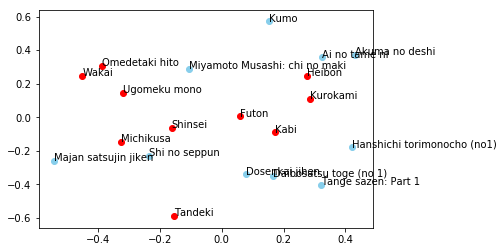

In [19]:
#visualize distances using multidimensional scaling
import os  # for os.path.basename
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]  #get all the x-values and y-values into separate variables

#create list of titles and genre from the metadata
names = df.TITLE.tolist()
genres = df.GENRE.tolist()

for x, y, name, genre in zip(xs, ys, names, genres):
    color = 'red' if genre == "SHISHOSETSU" else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)

plt.show()

## Visualize Cosine Distance as Dendrogram

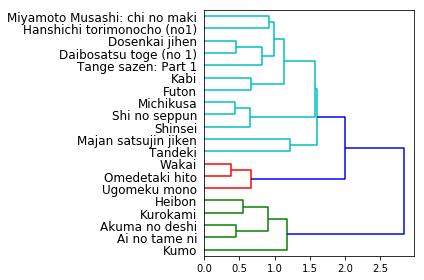

In [20]:
#cluster texts based on distance
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(cos_dist)
dendrogram(linkage_matrix, orientation="right", labels=names)
plt.tight_layout()  # fixes margins
plt.show()

## Part 2: Most Distinctive Word Analysis
This part of the notebook demonstrates some simple techniques for comparing two corpora based on their most distinctive words. In this case, "distinctive" may indicate any number of things. It can mean words that the two corpora don't share or it can mean words they do share but in significantly different amounts. Which measure of distinctiveness you use will depend on what kind of question you are trying to answer.

In [22]:
#Create some indices to keep track of which texts are I-novels and which are Popular texts

I_indices, P_indices = [], []

for index, genre in enumerate(df.GENRE.tolist()):
    if genre == "SHISHOSETSU":
        I_indices.append(index)
    elif genre == "POPULAR":
        P_indices.append(index)

In [46]:
#for this procedure we will use our reduced feature DTM

# Get word rates per 100 words for SHISOSETSU and POPULAR texts respectively
I_rates = red_norm_dtm[I_indices, :]
P_rates = red_norm_dtm[P_indices, :]

## Find Words Unique to Each Corpus

In [47]:
# Next we want the average rates of both groups, i.e. compute "column-wise mean"
I_rates_avg = np.mean(I_rates, axis=0)
P_rates_avg = np.mean(P_rates, axis=0)

# Let's now find any words that are totally unique to one group for latter use
# Since zero times any number is zero, this will identify texts where either
# author's average rate is zero; i.e. unique to I or P corpuses

distinctive_indices = (I_rates_avg * P_rates_avg) == 0

In [48]:
# Check! This number should be large but smaller than the total # of words
print(np.count_nonzero(distinctive_indices))

# Create separate dataframes for the unique words in each and sort by most frequent
ranking = np.argsort(I_rates_avg[distinctive_indices] + P_rates_avg[distinctive_indices]) # highest to lowest
I_distinctive_words = np.argsort(I_rates_avg[distinctive_indices])#[::-1] this reverses the order 
P_distinctive_words = np.argsort(P_rates_avg[distinctive_indices])#[::-1] 

107


In [49]:
#Most distinctive words in SHISHOSETSU
DataFrame([x for x in red_vocab[I_distinctive_words][ranking][0:25]])

,0
0,いか
1,あらわれ
2,かし
3,あんた
4,かた
5,おじさん
6,あたい
7,いささか
8,m
9,ぎり


In [50]:
#Most distinctive words in POPULAR corpus
DataFrame([x for x in red_vocab[P_distinctive_words][ranking][0:25]])

,0
0,いったい
1,あたし
2,おき
3,いよ
4,おいで
5,お前
6,こりゃ
7,えと
8,こい
9,こころ


## Find Distinctive Words that are Shared Across Corpora

In [56]:
# OK, now that we've identified the words that only exist in I or P corpuses, we'll
# remove them to focus only on the words that exist in both corpora

# This bit of code does that filtering work, filtering out the unique-to-one-corpus words
new_dtm = reduced_dtm[:, np.invert(distinctive_indices)]
new_rates = red_norm_dtm[:, np.invert(distinctive_indices)]
new_vocab = red_vocab[np.invert(distinctive_indices)]

In [53]:
# Now we have to recalculate our previous rates and rate-averages with our updated
# list of words, i.e. our lists filtered of the unique-to-one-corpus words
I_rates = new_rates[I_indices, :]
P_rates = new_rates[P_indices, :]
I_rates_avg = np.mean(I_rates, axis=0)
P_rates_avg = np.mean(P_rates, axis=0)

One way to identify a distinctive word is to calculate which words have the greatest difference in frequency across the two corpora. This difference is also known as **keyness**.

In [65]:
# calculate absolute value because we only care about the magnitude of the difference
keyness = np.abs(I_rates_avg - P_rates_avg)
ranking = np.argsort(keyness)[::-1]  # from highest to lowest

data = new_dtm[:, :] * keyness
keyness_value = DataFrame(data, index=filenames, columns=new_vocab)

In [66]:
#print the top 20 words according to keyness value
DataFrame([x for x in new_vocab[ranking][0:20]])

,0
0,自分
1,私
2,僕
3,女
4,博士
5,鶴
6,あなた
7,見
8,助
9,一


The above method may put too much attention on frequent words in both cases, ignoring those words that appear less frequently but which are still in both corpora. We might also want to look at those words. One imperfect solution is to divide the average rates for both groups by the total average rate across both groups. The idea is to divide all of these numbers by a big number, making those average rates smaller, thus getting rid of the too rare words

In [68]:
rates_avg = np.mean(new_rates, axis=0)
keyness2 = np.abs(I_rates_avg - P_rates_avg) / rates_avg
ranking = np.argsort(keyness2)[::-1]

In [74]:
# Inspect the top 50 words

top50 = new_vocab[ranking][0:49]
DataFrame([top50])

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,帆,鶴,殿,祖母,剣,自家,蜘蛛,麻布,博士,お袋,...,あい,自殺,田舎,ふう,屋敷,探偵,むこ,家族,病室,直


In [75]:
# Here is a more elegant presentation where you can see which vocab is more distinctive of which group

data = new_dtm[:, :] * keyness2
keyness_value2 = DataFrame(data, index=df.TITLE.tolist(), columns=new_vocab)

# Reduce dataframe to just the top 50 words
top50 = keyness_value2[ranking][0:49]
top50

,帆,鶴,殿,祖母,剣,自家,蜘蛛,麻布,博士,お袋,...,面白い,気の毒,泥,包ん,渡っ,喜ん,流れる,時に,気がつい,殊に
Tandeki,0.000000,0.000000,0.000000,0.000000,0.000000,1.985551,0.000000,0.000000,0.000000,130.725724,...,0.018886,0.003992,0.000000,0.005343,0.000000,0.000000,0.000000,0.000663,0.000080,0.000000
Majan satsujin jiken,131.835564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009443,0.000000,0.000000,0.000000,0.000000,0.001406,0.000000,0.000000,0.000080,0.000000
Hanshichi torimonocho (no1),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004722,0.011976,0.003526,0.002671,0.000000,0.001406,0.000000,0.000000,0.000000,0.000224
Kumo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,109.177356,0.000000,152.656310,0.000000,...,0.004722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Futon,0.000000,7.986332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004722,0.003992,0.017628,0.002671,0.023180,0.004218,0.000000,0.000331,0.000000,0.000336
Kurokami,0.000000,3.993166,0.000000,0.000000,0.000000,1.985551,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006322,0.001406,0.000909,0.000000,0.000159,0.000000
Kabi,0.000000,0.000000,0.000000,1.991526,0.000000,3.971101,1.985043,1.982954,0.000000,1.980693,...,0.018886,0.019960,0.000000,0.013357,0.012643,0.000000,0.000909,0.000000,0.000159,0.000000
Daibosatsu toge (no 1),0.000000,0.000000,25.911323,0.000000,25.869855,0.000000,1.985043,0.000000,0.000000,0.000000,...,0.009443,0.011976,0.007051,0.002671,0.002107,0.000000,0.001818,0.000331,0.000318,0.000000
Tange sazen: Part 1,1.997509,3.993166,101.652114,3.983051,583.066741,1.985551,25.805557,1.982954,0.000000,3.961386,...,0.000000,0.043913,0.042308,0.064115,0.046359,0.001406,0.010907,0.000663,0.001831,0.000037
Omedetaki hito,0.000000,604.964652,0.000000,3.983051,0.000000,41.696563,0.000000,3.965908,0.000000,0.000000,...,0.014165,0.011976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000331,0.000239,0.000112


## Add Metadata to the DataFrame and Print to File

In [76]:
# Some steps to make this dataframe look nicer
top50.reset_index(level=0, inplace=True)
top50.drop('index', axis=1, inplace=True)
top50.insert(0, 'genre', df.GENRE.tolist())
top50.insert(0, 'title', df.TITLE.tolist())

In [77]:
#sort the data frame by genre
top50 = top50.sort_values(by='genre')

# Write it out
from pandas import ExcelWriter
import xlsxwriter

writer = ExcelWriter(r'top_50_jp.xlsx', engine='xlsxwriter')
top50.to_excel(writer, sheet_name='Sheet1', encoding='utf-8')
writer.save()